In [1]:
import numpy as np
import pandas as pd

In [40]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "12"

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

2024-06-18 17:52:32.229577: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from utils import (
    splitter,
    create_plot,
    forecast_accuracy
)

In [5]:
# Check everything with Tensorflow works 
import sys

# import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
# print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-10.16-x86_64-i386-64bit
Tensor Flow Version: 2.12.0

Python 3.9.18 (main, Sep 11 2023, 08:20:50) 
[Clang 14.0.6 ]
Pandas 2.2.1
Scikit-Learn 1.4.1.post1
SciPy 1.12.0
GPU is available


In [6]:
metrics_ = pd.DataFrame()

### Loading the Dataset

In [7]:
ts_prices_eth = pd.read_csv("Data/Time_Series/prices/ethereum_19_22.csv",index_col='date',parse_dates=['date'])

In [8]:
# crypto = 'crypto_bitcoin'
crypto = 'crypto_ethereum'
# crypto = 'crypto_xrp'

In [9]:
ts_prices_eth.head(4) #.shape

,price
date,
2019-01-01,131.46
2019-01-02,138.14
2019-01-03,152.86
2019-01-04,146.73


In [10]:
df = ts_prices_eth

### Adding Features

In [11]:
df.tail()

,price
date,
2022-12-27,1226.25
2022-12-28,1211.82
2022-12-29,1188.73
2022-12-30,1201.54
2022-12-31,1199.11


In [12]:
n_lags = 14
for lag in range(1, n_lags + 1):
    df[f'price_lag_{lag}'] = df['price'].shift(lag)

In [13]:
window_sizes = [7, 14, 30]  # Window sizes for moving averages
for window_size in window_sizes:
    df[f'price_ma_{window_size}'] = df['price_lag_1'].rolling(window=window_size).mean()

In [14]:
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year

In [15]:
df.isna().sum()

price            0
price_lag_1      1
price_lag_2      2
price_lag_3      3
price_lag_4      4
price_lag_5      5
price_lag_6      6
price_lag_7      7
price_lag_8      8
price_lag_9      9
price_lag_10    10
price_lag_11    11
price_lag_12    12
price_lag_13    13
price_lag_14    14
price_ma_7       7
price_ma_14     14
price_ma_30     30
day_of_week      0
month            0
year             0
dtype: int64

In [16]:
df = df[30:]

### Only Price Features

In [17]:
df.columns

Index(['price', 'price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_4',
       'price_lag_5', 'price_lag_6', 'price_lag_7', 'price_lag_8',
       'price_lag_9', 'price_lag_10', 'price_lag_11', 'price_lag_12',
       'price_lag_13', 'price_lag_14', 'price_ma_7', 'price_ma_14',
       'price_ma_30', 'day_of_week', 'month', 'year'],
      dtype='object')

In [18]:
df.head()

,price,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5,price_lag_6,price_lag_7,price_lag_8,price_lag_9,price_lag_10,price_lag_11,price_lag_12,price_lag_13,price_lag_14,price_ma_7,price_ma_14,price_ma_30,day_of_week,month,year
date,,,,,,,,,,,,,,,,,,,,,
2019-01-31,108.27,104.60,105.35,112.51,115.34,115.15,116.25,116.42,117.82,115.83,117.61,122.93,119.17,121.93,122.25,112.231429,115.940000,127.918333,3,1,2019
2019-02-01,106.34,108.27,104.60,105.35,112.51,115.34,115.15,116.25,116.42,117.82,115.83,117.61,122.93,119.17,121.93,111.067143,114.941429,127.145333,4,2,2019
2019-02-02,107.01,106.34,108.27,104.60,105.35,112.51,115.34,115.15,116.25,116.42,117.82,115.83,117.61,122.93,119.17,109.651429,113.827857,126.085333,5,2,2019
2019-02-03,108.78,107.01,106.34,108.27,104.60,105.35,112.51,115.34,115.15,116.25,116.42,117.82,115.83,117.61,122.93,108.488571,112.959286,124.557000,6,2,2019
2019-02-04,107.20,108.78,107.01,106.34,108.27,104.60,105.35,112.51,115.34,115.15,116.25,116.42,117.82,115.83,117.61,107.551429,111.948571,123.292000,0,2,2019


In [19]:
test_split=round(len(df)*0.40)
df_for_training=df[:-test_split]
df_for_testing=df[-test_split:]
val_split=round(len(df_for_testing)*0.50)
df_for_validation=df_for_testing[:-val_split]
df_for_testing=df[-val_split:]
print(f"Training Set: {df_for_training.shape}")
print(f"Validation Set: {df_for_validation.shape}")
print(f"Testing Set: {df_for_testing.shape}")

Training Set: (859, 21)
Validation Set: (286, 21)
Testing Set: (286, 21)


In [20]:
print(df_for_training.index[0],df_for_training.index[-1])
print(df_for_validation.index[0],df_for_validation.index[-1])
print(df_for_testing.index[0],df_for_testing.index[-1])

2019-01-31 00:00:00 2021-06-07 00:00:00
2021-06-08 00:00:00 2022-03-20 00:00:00
2022-03-21 00:00:00 2022-12-31 00:00:00


In [21]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_validation_scaled=scaler.transform(df_for_validation)
df_for_training_scaled.shape, df_for_validation_scaled.shape

((859, 21), (286, 21))

In [22]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 1:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_for_training_scaled,30)
valX,valY=createXY(df_for_validation_scaled,30)

In [23]:
df.shape

(1431, 21)

In [24]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(30,return_sequences=True,input_shape=(30,20)))
    grid_model.add(LSTM(30))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(valX,valY))
parameters = {'batch_size' : [16,20],
            'epochs' : [8,10],
            'optimizer' : ['adam'] }
grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

/var/folders/2l/h6ht9_t96fn33pfzbxcdp_dm0000gn/T/ipykernel_8764/2823166080.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(valX,valY))


In [25]:
grid_search = grid_search.fit(trainX,trainY)

2024-06-18 17:52:50.451447: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-18 17:52:50.451516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-06-18 17:52:50.953617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:52:50.955563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] 

Epoch 1/8


2024-06-18 17:52:51.722502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:52:51.724287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:52:51.725472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 0.0096

2024-06-18 17:52:57.092531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:52:57.093977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:52:57.095168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 7s 92ms/step - loss: 0.0096 - val_loss: 0.0237
Epoch 2/8
26/26 [==============================] - 1s 38ms/step - loss: 0.0044 - val_loss: 0.0128
Epoch 3/8
26/26 [==============================] - 1s 38ms/step - loss: 0.0052 - val_loss: 0.0273
Epoch 4/8
26/26 [==============================] - 1s 38ms/step - loss: 0.0037 - val_loss: 0.0201
Epoch 5/8
26/26 [==============================] - 1s 37ms/step - loss: 0.0037 - val_loss: 0.0236
Epoch 6/8
26/26 [==============================] - 1s 41ms/step - loss: 0.0031 - val_loss: 0.0404
Epoch 7/8
26/26 [==============================] - 1s 40ms/step - loss: 0.0034 - val_loss: 0.0215
Epoch 8/8
26/26 [==============================] - 1s 38ms/step - loss: 0.0036 - val_loss: 0.0297


2024-06-18 17:53:05.266163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:53:05.267832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:53:05.268912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 2s 20ms/step - loss: 0.0021


2024-06-18 17:53:07.092259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:53:07.093754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:53:07.094832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-18 17:53:07.552594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:53:07.554266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:53:07.555436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 6.3850e-04

2024-06-18 17:53:13.007702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:53:13.009211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:53:13.010314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 7s 86ms/step - loss: 6.3850e-04 - val_loss: 0.2910
Epoch 2/8
26/26 [==============================] - 1s 38ms/step - loss: 1.8774e-04 - val_loss: 0.2273
Epoch 3/8
26/26 [==============================] - 1s 38ms/step - loss: 1.4201e-04 - val_loss: 0.1916
Epoch 4/8
26/26 [==============================] - 1s 38ms/step - loss: 9.6974e-05 - val_loss: 0.2145
Epoch 5/8
26/26 [==============================] - 1s 40ms/step - loss: 9.2969e-05 - val_loss: 0.2069
Epoch 6/8
26/26 [==============================] - 1s 38ms/step - loss: 9.2396e-05 - val_loss: 0.1760
Epoch 7/8
26/26 [==============================] - 1s 38ms/step - loss: 7.4087e-05 - val_loss: 0.1894
Epoch 8/8
26/26 [==============================] - 1s 38ms/step - loss: 7.4100e-05 - val_loss: 0.1780


2024-06-18 17:53:21.041354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:53:21.042951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:53:21.044188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 15ms/step - loss: 0.0193


2024-06-18 17:53:22.391846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:53:22.393394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:53:22.394584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-18 17:53:22.899274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:53:22.902137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:53:22.904389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 0.0280

2024-06-18 17:53:27.842384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:53:27.843880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:53:27.845016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 7s 107ms/step - loss: 0.0280 - val_loss: 0.0185
Epoch 2/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0060 - val_loss: 0.0240
Epoch 3/10
26/26 [==============================] - 1s 46ms/step - loss: 0.0056 - val_loss: 0.0256
Epoch 4/10
26/26 [==============================] - 2s 59ms/step - loss: 0.0051 - val_loss: 0.0180
Epoch 5/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0042 - val_loss: 0.0217
Epoch 6/10
26/26 [==============================] - 1s 37ms/step - loss: 0.0044 - val_loss: 0.0251
Epoch 7/10
26/26 [==============================] - 1s 41ms/step - loss: 0.0046 - val_loss: 0.0292
Epoch 8/10
26/26 [==============================] - 1s 42ms/step - loss: 0.0035 - val_loss: 0.0397
Epoch 9/10
26/26 [==============================] - 1s 38ms/step - loss: 0.0040 - val_loss: 0.0154
Epoch 10/10
26/26 [==============================] - 1s 48ms/step - loss: 0.0041 - val_loss: 0.0186


2024-06-18 17:53:39.605919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:53:39.607415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:53:39.608434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 14ms/step - loss: 3.2094e-04


2024-06-18 17:53:40.929023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:53:40.930430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:53:40.931723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-18 17:53:41.888730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:53:41.890393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:53:41.891508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - ETA: 0s - loss: 0.0023

2024-06-18 17:53:46.778073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:53:46.779490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:53:46.780680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 7s 86ms/step - loss: 0.0023 - val_loss: 0.6940
Epoch 2/10
26/26 [==============================] - 1s 41ms/step - loss: 4.9514e-04 - val_loss: 0.4882
Epoch 3/10
26/26 [==============================] - 1s 52ms/step - loss: 2.1198e-04 - val_loss: 0.3982
Epoch 4/10
26/26 [==============================] - 1s 47ms/step - loss: 1.8776e-04 - val_loss: 0.3202
Epoch 5/10
26/26 [==============================] - 1s 38ms/step - loss: 1.6327e-04 - val_loss: 0.2790
Epoch 6/10
26/26 [==============================] - 1s 40ms/step - loss: 1.2096e-04 - val_loss: 0.3058
Epoch 7/10
26/26 [==============================] - 1s 38ms/step - loss: 1.0300e-04 - val_loss: 0.3024
Epoch 8/10
26/26 [==============================] - 1s 44ms/step - loss: 9.8061e-05 - val_loss: 0.3076
Epoch 9/10
26/26 [==============================] - 1s 38ms/step - loss: 9.6741e-05 - val_loss: 0.3170
Epoch 10/10
26/26 [==============================] - 1s 39ms/step - loss: 8.7719e-05 - v

2024-06-18 17:53:57.806664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:53:57.808276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:53:57.809442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

26/26 [==============================] - 1s 15ms/step - loss: 0.0370


2024-06-18 17:53:59.217546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:53:59.219118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:53:59.220163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-18 17:53:59.679745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:53:59.681502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:53:59.682718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 0.0203

2024-06-18 17:54:04.540943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:54:04.542556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:54:04.543664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 6s 113ms/step - loss: 0.0203 - val_loss: 0.0201
Epoch 2/8
21/21 [==============================] - 1s 42ms/step - loss: 0.0083 - val_loss: 0.0137
Epoch 3/8
21/21 [==============================] - 1s 41ms/step - loss: 0.0053 - val_loss: 0.0130
Epoch 4/8
21/21 [==============================] - 1s 44ms/step - loss: 0.0052 - val_loss: 0.0191
Epoch 5/8
21/21 [==============================] - 1s 41ms/step - loss: 0.0035 - val_loss: 0.0119
Epoch 6/8
21/21 [==============================] - 1s 43ms/step - loss: 0.0034 - val_loss: 0.0212
Epoch 7/8
21/21 [==============================] - 1s 48ms/step - loss: 0.0038 - val_loss: 0.0108
Epoch 8/8
21/21 [==============================] - 0s 16ms/step - loss: 2.0071e-04


2024-06-18 17:54:12.480955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:54:12.482487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:54:12.483568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-18 17:54:13.555633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:54:13.557351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:54:13.558538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 9.6197e-04

2024-06-18 17:54:18.384214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:54:18.385922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:54:18.387119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 6s 111ms/step - loss: 9.6197e-04 - val_loss: 0.2538
Epoch 2/8
21/21 [==============================] - 1s 42ms/step - loss: 2.1079e-04 - val_loss: 0.1799
Epoch 3/8
21/21 [==============================] - 1s 42ms/step - loss: 1.3480e-04 - val_loss: 0.1604
Epoch 4/8
21/21 [==============================] - 1s 42ms/step - loss: 1.0598e-04 - val_loss: 0.1622
Epoch 5/8
21/21 [==============================] - 1s 41ms/step - loss: 1.1176e-04 - val_loss: 0.1676
Epoch 6/8
21/21 [==============================] - 1s 41ms/step - loss: 8.3182e-05 - val_loss: 0.1620
Epoch 7/8
21/21 [==============================] - 1s 41ms/step - loss: 7.8554e-05 - val_loss: 0.1778
Epoch 8/8
21/21 [==============================] - 0s 16ms/step - loss: 0.0209


2024-06-18 17:54:26.074658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:54:26.076206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:54:26.077293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-18 17:54:26.525053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:54:26.526571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:54:26.527807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 0.0081

2024-06-18 17:54:31.389404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:54:31.390961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:54:31.392170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 6s 111ms/step - loss: 0.0081 - val_loss: 0.0286
Epoch 2/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0048 - val_loss: 0.0192
Epoch 3/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0046 - val_loss: 0.0322
Epoch 4/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0050 - val_loss: 0.0212
Epoch 5/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0041 - val_loss: 0.0178
Epoch 6/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0038 - val_loss: 0.0185
Epoch 7/10
21/21 [==============================] - 1s 46ms/step - loss: 0.0032 - val_loss: 0.0334
Epoch 8/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0032 - val_loss: 0.0109
Epoch 9/10
21/21 [==============================] - 1s 41ms/step - loss: 0.0032 - val_loss: 0.0372
Epoch 10/10
21/21 [==============================] - 0s 16ms/step - loss: 1.5823e-04


2024-06-18 17:54:40.815843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:54:40.817330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:54:40.818327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2024-06-18 17:54:41.670206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:54:41.672038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:54:41.673291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - ETA: 0s - loss: 0.0013

2024-06-18 17:54:46.466920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:54:46.468585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:54:46.469640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

21/21 [==============================] - 6s 110ms/step - loss: 0.0013 - val_loss: 0.5599
Epoch 2/10
21/21 [==============================] - 1s 42ms/step - loss: 3.3736e-04 - val_loss: 0.4583
Epoch 3/10
21/21 [==============================] - 1s 41ms/step - loss: 1.8548e-04 - val_loss: 0.3761
Epoch 4/10
21/21 [==============================] - 1s 42ms/step - loss: 1.3107e-04 - val_loss: 0.3497
Epoch 5/10
21/21 [==============================] - 1s 45ms/step - loss: 9.9511e-05 - val_loss: 0.3635
Epoch 6/10
21/21 [==============================] - 1s 43ms/step - loss: 9.8304e-05 - val_loss: 0.3584
Epoch 7/10
21/21 [==============================] - 1s 41ms/step - loss: 8.5073e-05 - val_loss: 0.3523
Epoch 8/10
21/21 [==============================] - 1s 56ms/step - loss: 7.6111e-05 - val_loss: 0.3631
Epoch 9/10
21/21 [==============================] - 1s 43ms/step - loss: 6.9432e-05 - val_loss: 0.3754
Epoch 10/10
21/21 [==============================] - 0s 21ms/step - loss: 0.0477


2024-06-18 17:54:56.711803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:54:56.713637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:54:56.715068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/8


2024-06-18 17:54:56.951065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:54:56.952717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:54:56.953787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

42/42 [==============================] - ETA: 0s - loss: 0.0062

2024-06-18 17:55:06.236076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:55:06.237893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:55:06.239050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

42/42 [==============================] - 10s 92ms/step - loss: 0.0062 - val_loss: 0.0287
Epoch 2/8
42/42 [==============================] - 2s 37ms/step - loss: 0.0029 - val_loss: 0.0445
Epoch 3/8
42/42 [==============================] - 2s 45ms/step - loss: 0.0022 - val_loss: 0.0226
Epoch 4/8
42/42 [==============================] - 2s 38ms/step - loss: 0.0024 - val_loss: 0.0221
Epoch 5/8
42/42 [==============================] - 2s 36ms/step - loss: 0.0020 - val_loss: 0.0216
Epoch 6/8
42/42 [==============================] - 2s 47ms/step - loss: 0.0018 - val_loss: 0.0241
Epoch 7/8
42/42 [==============================] - 2s 37ms/step - loss: 0.0015 - val_loss: 0.0285
Epoch 8/8
42/42 [==============================] - 2s 36ms/step - loss: 0.0013 - val_loss: 0.0278


In [26]:
grid_search.best_params_

{'batch_size': 20, 'epochs': 8, 'optimizer': 'adam'}

In [27]:
model_only_price=grid_search.best_estimator_.model

In [28]:
model_only_price.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 30, 30)            6120      
                                                                 
 lstm_17 (LSTM)              (None, 30)                7320      
                                                                 
 dropout_8 (Dropout)         (None, 30)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 31        
                                                                 
Total params: 13,471
Trainable params: 13,471
Non-trainable params: 0
_________________________________________________________________


In [29]:
df_for_validation[-30:].shape, df_for_validation[-30:].index[0]

((30, 21), Timestamp('2022-02-19 00:00:00'))

In [30]:
df_for_testing = pd.concat([df_for_validation[-30:],df_for_testing])

In [31]:
df_for_testing.shape

(316, 21)

In [32]:
df_for_testing_scaled = scaler.transform(df_for_testing)
testX,testY=createXY(df_for_testing_scaled,30)
pred = model_only_price.predict(testX)
prediction_copies_array = np.repeat(pred,21, axis=-1)
predicted_prices = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(pred),21)))[:,0]

2024-06-18 17:55:49.823880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-06-18 17:55:49.825669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-06-18 17:55:49.826957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

9/9 [==============================] - 2s 64ms/step


In [33]:
df_for_testing[30:].shape,predicted_prices.shape

((286, 21), (286,))

In [34]:
n_df= pd.DataFrame()
n_df.index = df_for_testing[30:].index
n_df['price'] = predicted_prices

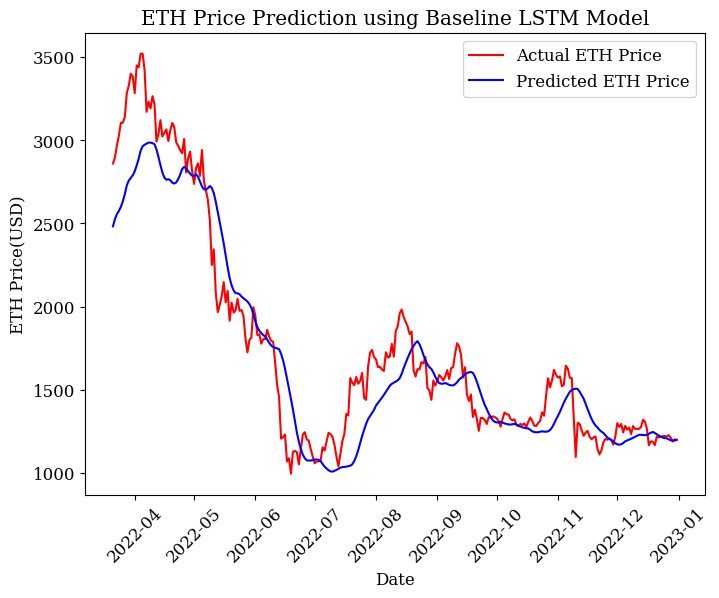

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(df_for_testing['price'].iloc[30:], color = 'red', label = 'Actual ETH Price')
plt.plot(n_df['price'], color = 'blue', label = 'Predicted ETH Price')
plt.title('ETH Price Prediction using Baseline LSTM Model')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('ETH Price(USD)')
plt.legend()
plt.show()

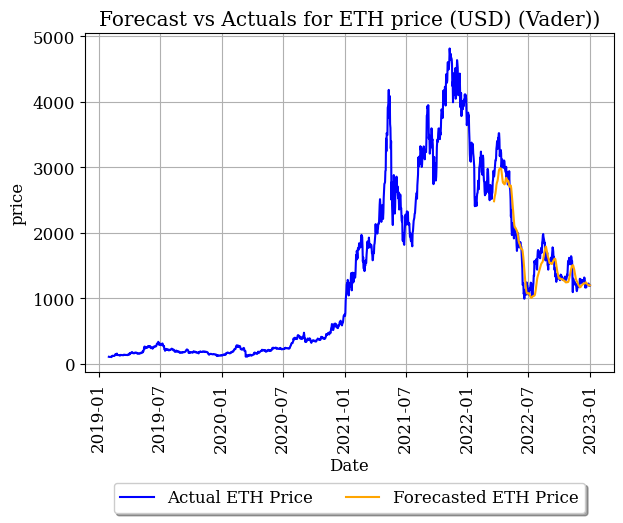

In [42]:
create_plot(n_df['price'],df['price'], 'ETH', 'Vader')

In [43]:
res = forecast_accuracy(n_df['price'], df_for_testing['price'].iloc[30:],['ETH_Baseline'])
res

,MAE,MAPE,MSE,RMSE
ETH_Baseline,170.232155,9.706252,52161.592901,228.389126


In [44]:
model_only_price.save("ETH_Baseline_LSTModel.keras")